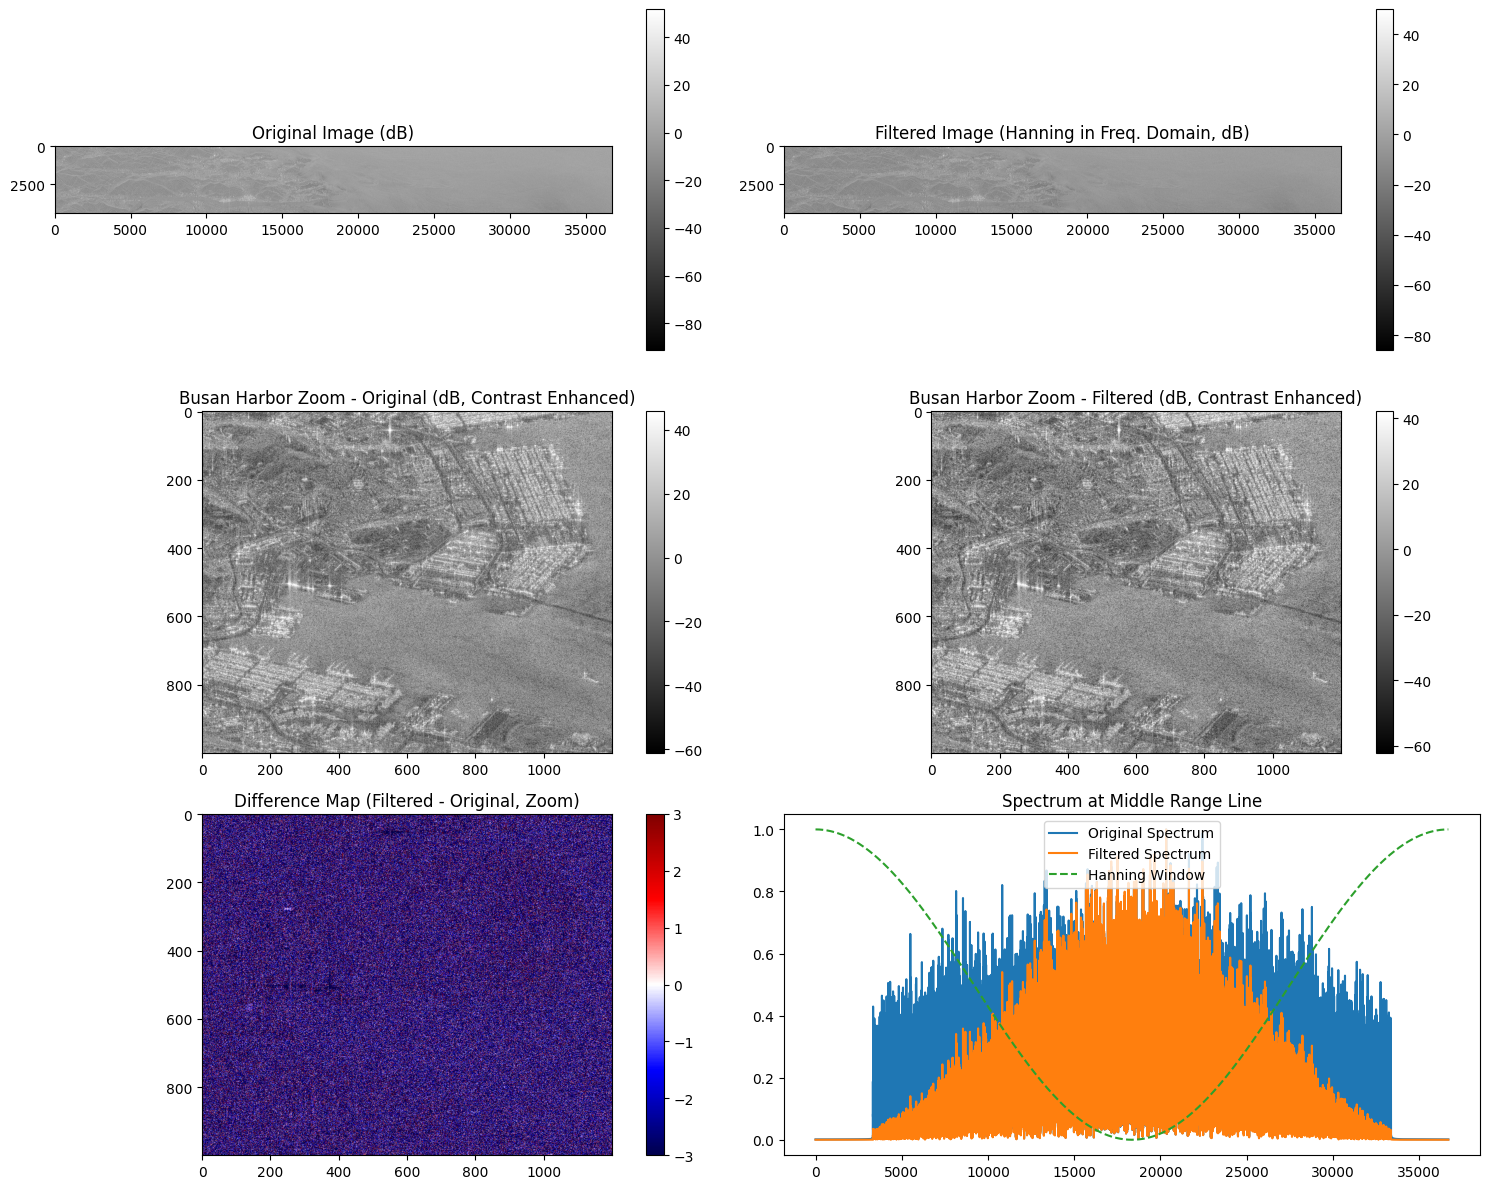

In [10]:
"""
SAR Image Processing and Visualization Script

This script reads a NITF-format SAR image of Busan Harbor using SarPy, processes
its frequency spectrum, applies a Hanning window filter, and visualizes multiple
stages of the SAR image in both original and filtered forms.

Key functionalities:
- Load SAR image from NITF format
- Convert to magnitude and dB scale
- Compute and visualize the 2D FFT spectrum
- Apply Hanning window filter in frequency domain
- Perform inverse FFT to reconstruct filtered image
- Generate multiple plots:
    1. Original image (dB scale)
    2. Spectrum of original image
    3. Filter mask visualization
    4. Filtered spectrum
    5. Filtered image (dB scale)
    6. Busan Harbor Zoom - Original (contrast enhanced, cropped)
    7. Busan Harbor Zoom - Filtered (contrast enhanced, cropped)

Enhancements:

- A simple contrast stretching is applied to the Busan harbor zoom regio for better visibility.

Author: Gorakh Nath Chaubey
"""


from sarpy.io.general.nitf import NITFReader
from scipy.fft import fft, ifft, fftshift
import matplotlib.pyplot as plt
import numpy as np

# --------------------------
# Load SAR Image
# --------------------------
file_path = "IMG-VV-STRIXB-20220811T004713Z-SMSLC-SICD.nitf"
reader = NITFReader(file_path)
img = reader[:].squeeze()  # full complex array
#print(f"Loaded image shape: {img.shape}, dtype: {img.dtype}")

# --------------------------
# FFT → Apply Hanning → IFFT
# --------------------------
def apply_hanning_frequency_window(data):
    nr, na = data.shape
    hann = np.hanning(na)
    hann_shifted = fftshift(hann)

    filtered_data = np.zeros_like(data, dtype=np.complex64)

    for r in range(nr):
        spectrum = fft(data[r, :])
        spectrum_filtered = spectrum * hann_shifted
        filtered_data[r, :] = ifft(spectrum_filtered)

    return filtered_data, hann_shifted

filtered_img, hann_win = apply_hanning_frequency_window(img)

# --------------------------
# Magnitude (dB scale)
# --------------------------
orig_mag = 20 * np.log10(np.abs(img) + 1e-6)
filt_mag = 20 * np.log10(np.abs(filtered_img) + 1e-6)
diff_map = filt_mag - orig_mag

# --------------------------
# Spectral plot (middle row)
# --------------------------
mid_row = img.shape[0] // 2
orig_spec = np.abs(fftshift(fft(img[mid_row, :])))
filt_spec = np.abs(fftshift(fft(filtered_img[mid_row, :])))

# --------------------------
# Busan harbor crop (can be adjusted as needed)
# --------------------------
row_start, row_end = 1000, 2000
col_start, col_end = 13200, 14400

orig_crop = orig_mag[row_start:row_end, col_start:col_end]
filt_crop = filt_mag[row_start:row_end, col_start:col_end]
diff_crop = diff_map[row_start:row_end, col_start:col_end]

# Contrast enhancement (simple stretching)
def enhance_contrast(arr, factor=3.0):
    mean_val = np.mean(arr)
    return np.clip((arr - mean_val) * factor + mean_val, arr.min(), arr.max())

orig_crop_contrast = enhance_contrast(orig_crop, factor=2.0)
filt_crop_contrast = enhance_contrast(filt_crop, factor=2.0)

# --------------------------
# Plot results
# --------------------------
plt.figure(figsize=(15, 12))

# Original
plt.subplot(3, 2, 1)
plt.imshow(orig_mag, cmap='gray')
plt.title("Original Image (dB)")
plt.colorbar()

# Filtered
plt.subplot(3, 2, 2)
plt.imshow(filt_mag, cmap='gray')
plt.title("Filtered Image (Hanning in Freq. Domain, dB)")
plt.colorbar()

# Crop - Original (Contrast Enhanced)
plt.subplot(3, 2, 3)
plt.imshow(orig_crop_contrast, cmap='gray')
plt.title("Busan Harbor Zoom - Original (dB, Contrast Enhanced)")
plt.colorbar()

# Crop - Filtered (Contrast Enhanced)
plt.subplot(3, 2, 4)
plt.imshow(filt_crop_contrast, cmap='gray')
plt.title("Busan Harbor Zoom - Filtered (dB, Contrast Enhanced)")
plt.colorbar()

# Difference Map (Zoom)
plt.subplot(3, 2, 5)
plt.imshow(diff_crop, cmap='seismic', vmin=-3, vmax=3)
plt.title("Difference Map (Filtered - Original, Zoom)")
plt.colorbar()

# Spectrum plot
plt.subplot(3, 2, 6)
plt.plot(orig_spec / np.max(orig_spec), label="Original Spectrum")
plt.plot(filt_spec / np.max(filt_spec), label="Filtered Spectrum")
plt.plot(hann_win, label="Hanning Window", linestyle="--")
plt.title("Spectrum at Middle Range Line")
plt.legend()

plt.tight_layout()
plt.show()
